In [332]:
import json
import matplotlib.pyplot as plt
import os
from collections import defaultdict, OrderedDict
import random
from scipy.interpolate import make_interp_spline
from dtaidistance import dtw
import numpy as np
import sys

In [3]:
def load_dataset(datadir, combine_tokens=False, tokens=None, backspaces=False):
    """
    Parent function for loading the dataset.

    datadir -> Parent directory of .json files with the keystroke data.
    combine_tokens (bool) -> Should common tokens be extracted into a new keyword?
    tokens (set) -> Set of tokens to extract into keywords.
    backspaces (bool) -> If True, backspaces will be kept- otherwise, feed to handle_backspaces (default)
    """
    data = {'sessions': []}

    # Load JSON files
    files = [fname for fname in os.listdir(datadir) if fname.endswith('.json')]
    
    for file in files:
        with open(f"{datadir}{file}", "r") as f:
            js = json.load(f)
            data['sessions'].extend(js['sessions'])

    # Turn dict into command -> [[keystrokes]] map
    commands = defaultdict(list)
    for session in data['sessions']:
        command = session['command']
        keystrokes = session['keystrokes']
        if len(keystrokes) == 0 or len(keystrokes) < len(command):
               continue
        commands[command].append(keystrokes)

    # Zero the first latency for each session.
    for cmd in commands.keys():
        for session in commands[cmd]:
            session[0]['latency'] = 0

    # Requires backspaces to be handled beforehand
    if combine_tokens and tokens:
        commands = handle_backspaces(commands)
        commands = combine_common_tokens(commands, tokens)
    elif not backspaces:
        commands = handle_backspaces(commands)

    return commands

In [4]:
def combine_common_tokens(dataset, common_tokens: set):
    """
    Certain keywords are reused in the dataset. We can combine them for increased coverage.
    i.e. sudo, install, apt, service, etc.
    
    # common_tokens = set(["sudo", "install", "service", "pacman", "systemctl"])
    """
    aggregated_data = defaultdict(list)

    for command, sessions in dataset.items():
        splices = command.split()
        indices = [0]
        
        # Accumulate indices positions
        for i in range(1, len(splices)):
            indices.append(indices[-1] + len(splices[i-1]) + 1)  # Account for spaces

        for i, word in enumerate(splices):
            if word in common_tokens:
                start_idx = indices[i]
                end_idx = start_idx + len(word)  # Not including the space after the word

                # Extract the keystrokes corresponding to the word
                keystrokes = [session[start_idx:end_idx] for session in sessions]
                
                # Optionally nullify the first latency in each session to normalize start time
                for keystroke in keystrokes:
                    if keystroke:  # Ensure it's not an empty list
                        keystroke[0]['latency'] = 0

                aggregated_data[word].extend(keystrokes)

        # Add the full command data
        aggregated_data[command].extend(sessions)

    return aggregated_data

In [5]:
def handle_backspaces(dataset):
    """
    Account for backspaces in a session by removing the extra keystroke.

    Latencies are not modified, so the latency between a "false" keystroke and the next "correct" keystroke prevails.
    Remains to be seen what the most optimal solution for this is; this seemed to work "okay", however.
    """
    for command in dataset.keys():
        for sequence in dataset[command]:
            i = 0
            while i < len(sequence)-1:
                if sequence[i]['key'] == 'Backspace':
                    curr = sequence[i]
                    prev = sequence[i-1]
                    if i != 0:
                        sequence.remove(prev)
                        sequence.remove(curr)
                        i -= 1
                        continue
                    else:
                        sequence.remove(curr)
                        sequence[i+1]['latency'] = 0
                        continue
                i += 1
    return dataset

In [6]:
def plot_command_latencies(keystroke_sequences, command):
    """
    Plot all latencies of a given command together.

    Latency (y) is in milliseconds.
    X-axis shows the keystroke id.
    """
    plt.figure(figsize=(12, 8))
    
    for sequence_idx, sequence in enumerate(keystroke_sequences):
        normal_keys_x = []
        normal_keys_y = []
        backspace_keys_x = []
        backspace_keys_y = []
        
        for keystroke_idx, keystroke in enumerate(sequence):
            if keystroke['key'] == 'Backspace':
                backspace_keys_x.append(keystroke_idx)
                backspace_keys_y.append(keystroke['latency'])
            normal_keys_x.append(keystroke_idx)
            normal_keys_y.append(keystroke['latency'])

        # Plot normal keystrokes
        plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', label=f'Session {sequence_idx + 1} Keystrokes', zorder=1)
        # Plot Backspace keystrokes
        plt.scatter(backspace_keys_x, backspace_keys_y, color='red', marker='x', label=f'Session {sequence_idx + 1} Backspaces', zorder=2)

    plt.title(f'Latencies for Command: {command}')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

In [7]:
def plot_command_distribution(keystroke_sequences, command):
    """
    Plot all latencies of a given command together, including the mean latency line.

    Will render an extra phantom-keystroke (return) for keywords taken from tokenisation (combine_common_tokens).
    """
    plt.figure(figsize=(12, 8))

    total_latencies = [0] * (len(command) + 1)
    count_per_position = [0] * (len(command) + 1)

    # Plot each keystroke sequence
    for sequence in keystroke_sequences:
        normal_keys_x = []
        normal_keys_y = []
        
        for idx, keystroke in enumerate(sequence):
            normal_keys_x.append(idx)
            normal_keys_y.append(keystroke['latency'])
            if idx < len(total_latencies):
                total_latencies[idx] += keystroke['latency']
                count_per_position[idx] += 1

        plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', color='blue', alpha=0.3, zorder=1)
    
    # Calculate mean latencies
    means = [total_latencies[i] / count_per_position[i] if count_per_position[i] else 0 for i in range(len(command)+1)]
    x_new = np.linspace(0, len(command), 300)  # 300 represents number of points to make between T.min and T.max

    # Smoothing the line
    spl = make_interp_spline(range(len(command)+1), means, k=3)  # BSpline object
    y_smooth = spl(x_new)

    plt.plot(x_new, y_smooth, marker='', linestyle='-', label='Mean keystroke latency', color='red', linewidth=2, zorder=2)

    plt.title(f'Mean latencies for command: "{command}"')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()

In [347]:
def load_ssh_session(path, stream=0):
    """
    Load SSHniff session (JSON) output.

    By default, assume single-session, which will have stream="0".
    """
    stream = str(stream)
    
    with open(path, "r") as f:
        data = json.loads(f.read())
    # SSHniff full output
    if 'keystroke_data' in data[stream]:
        return convert_latencies(data[stream]['keystroke_data'])
    # Only keystroke data
    return convert_latencies(data[stream])

In [334]:
def convert_latencies(ssh_data):
    """
    Convert latencies from microseconds to milliseconds. 
    """
    for sequence in ssh_data:
        for keystroke in sequence:
            keystroke['timestamp'] = keystroke['timestamp'] / 1000
    return ssh_data

In [335]:
def handle_ssh_backspaces(ssh_data):
    """
    Account for backspaces in a session by removing the extra keystroke.

    This should mirror the implementation for `handle_backspaces`.
    """
    pass

In [336]:
def plot_ssh_latency(sequence):
    """
    Plots SSH keystrokes (unlabeled).

    Y-Axis: Latency (ms)
    X-Axis: Keystroke ID
    """
    plt.figure(figsize=(12, 8))
    normal_keys_x = []
    normal_keys_y = []
    backspace_keys_x = []
    backspace_keys_y = []
    enter_keys_x = []
    enter_keys_y = []

    for keystroke_idx, keystroke in enumerate(sequence):
        if keystroke['k_type'] == 'Delete':
            backspace_keys_x.append(keystroke_idx)
            backspace_keys_y.append(keystroke['timestamp'])
        elif keystroke['k_type'] == 'Enter':
            enter_keys_x.append(keystroke_idx)
            enter_keys_y.append(keystroke['timestamp'])
        normal_keys_x.append(keystroke_idx)
        normal_keys_y.append(keystroke['timestamp'])
                
    # Plot normal keystrokes
    plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', label=f'Session 1 Keystrokes', zorder=1)
    # Plot Backspace keystrokes
    plt.scatter(backspace_keys_x, backspace_keys_y, color='red', marker='x', label=f'Session 1 Backspaces', zorder=2)
    plt.scatter(enter_keys_x, enter_keys_y, color='green', marker='x', label=f'Session 1 Return', zorder=3)

    plt.title(f'Latencies for SSH sequence')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

In [337]:
def plot_ssh_sessions(ssh_sessions):
    """
    Plots SSH sessions 
    """
    plt.figure(figsize=(12, 8))
    
    for sequence_idx, sequence in enumerate(ssh_sessions):
        keystroke_times = [event['timestamp'] for event in sequence if event['k_type'] == 'Keystroke']  # Convert to milliseconds
        enter_times = [event['timestamp'] for event in sequence if event['k_type'] == 'Enter']
        enter_sizes = [event['response_size'] for event in sequence if event['k_type'] == 'Enter']
        
        # Plotting keystrokes
        plt.plot(keystroke_times, [sequence_idx + 1] * len(keystroke_times), 'bo', label='Keystrokes' if sequence_idx == 0 else "")
        
        # Plotting Enter presses
        for enter_time, size in zip(enter_times, enter_sizes):
            plt.plot(enter_time, sequence_idx + 1, 'rx', label='Enter Press' if sequence_idx == 0 else "")
            plt.text(enter_time, sequence_idx + 1, f' {size}B', verticalalignment='bottom')

    plt.yticks(range(1, len(ssh_sessions) + 1), [f'Sequence {i+1}' for i in range(len(ssh_sessions))])
    plt.title('SSH Packet Timestamps and Returned Data Size')
    plt.xlabel('Time (ms)')
    plt.ylabel('Sequence Number')
    plt.legend()
    plt.grid(True)
    plt.show()

In [338]:
def plot_ssh_vs_command(ssh_sequence, command_mean_latencies, command):
    """
    Plots an observed SSH sequence's latencies against the mean of the guessed (or any) command.
    """
    plt.figure(figsize=(12, 8))
    ssh_latencies = [keystroke['timestamp'] for keystroke in ssh_sequence if keystroke['k_type'] == 'Keystroke']

    # Plot observed SSH sequence latencies
    plt.plot(range(len(ssh_latencies)), ssh_latencies, color='blue', marker='o', linestyle='-', label='Observed SSH Keystrokes', zorder=2)

    # Plot command mean latencies
    # Interpolation for smoothness
    x_new = np.linspace(0, len(command_mean_latencies) - 1, 300)  # 300 points for smooth line
    spl = make_interp_spline(range(len(command_mean_latencies)), command_mean_latencies, k=3)  # BSpline object
    y_smooth = spl(x_new)
    
    plt.plot(x_new, y_smooth, 'r-', label='Mean Command Latencies', linewidth=2, zorder=1)

    plt.title(f'Observed SSH Latencies vs. "{command}" Command Mean Latencies')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [339]:
def get_mean_latencies(command, command_dataset):
    """
    Calculates mean latency per keystroke pair for a given command.

    Expects get_mean_latencies('id', cmds['id'])
    Ignores RET, unless command has an extra character at the end.
        i.e. "sudo apt update " <--- the space will cause the RET 
        at the end to also be included in the mean latencies.
    Returns a numpy array of the means, with length == len(command).
    """
    means = [0 for i in range(len(command))]
    for letter_index, letter in enumerate(command):
        for sequence in command_dataset:
            means[letter_index] += sequence[letter_index]['latency']
    means = [i / len(command_dataset) for i in means]
    return np.array(means)

In [340]:
def eliminate_candidates(intercept_length, command_dataset):
    """
    Reduces the scope of possible commands.

    Using the intercepted command's length, we can exclude commands with 
    a minimum length longer than the intercept. 
        i.e.: A five-letter intercept (XXXXX) cannot be ifconfig, no matter
        how well the signature might match.
    """
    candidates = {}
    for command in command_dataset.keys():
        splices = command.split(' ')
#        if splices[0] == 'sudo':
#            if len(splices[1]) + 5 > intercept_length:
#                # Ignore command if itself 
#                continue
        # Ignore command
        if len(splices[0]) > intercept_length:
            continue
        else:
            candidates[command] = command_dataset[command]
    return candidates

In [341]:
def find_best_match(intercepted, command_dataset):
    """
    Creates an ordered list of the distance of all possible commands to an intercepted sequence.

    Distance is calculated using Dynamic Time Warping (DTW). 
    Latencies are normalised before being fed to dtw- show significantly better results.
    """
    # Normalise intercepted keystrokes
    unlabeled_latencies = np.array([keystroke['timestamp'] for keystroke in intercepted])
    unlabeled_norm = unlabeled_latencies / np.max(unlabeled_latencies)

    distances = []
    # Only consider commands that have a min_len >= len(intercepted)
    candidates = eliminate_candidates(len(intercepted), command_dataset)
    for command in candidates.keys():
        try:
            # Get mean keystroke latencies, but only up to len(intercepted)
            cmd_mean_latencies = get_mean_latencies(command, command_dataset[command])[:len(intercepted)]
        except:
            print(f"failed at {command}")
            continue

        known_norm = cmd_mean_latencies / np.max(cmd_mean_latencies)
        distance = dtw.distance(unlabeled_norm, known_norm)
        distances.append((command, distance))

    distances = sorted(distances, key=lambda x: x[1])
    return distances

In [342]:
def is_it_sudo(intercepted, command_dataset) -> bool:
    """
    Determines whether the first five keystrokes are similar to "sudo ".

    Assumes len(intercepted) >= 5.
    """
    return find_best_match(intercepted[:6], command_dataset)[0][0] == 'sudo'

In [343]:
# Load one
cmds = load_dataset(datadir="./personalised_data/", combine_tokens=True, tokens=set(["sudo","systemctl"]), backspaces=False)
#cmds2 = load_dataset(datadir="./data/", combine_tokens=True, tokens=set(["sudo","systemctl"]), backspaces=False)

In [257]:
# Load both
cmds = load_dataset(datadir="./personalised_data/", combine_tokens=True, tokens=set(["sudo","systemctl"]), backspaces=False)
cmds2 = load_dataset(datadir="./data/", combine_tokens=True, tokens=set(["sudo","systemctl"]), backspaces=False)

for key in cmds2.keys():
    if key in cmds:
        cmds[key].extend(cmds2[key])
    else:
        cmds[key] = cmds2[key]

In [348]:
ssh = load_ssh_session("./sshniff_output/capture_2_ssh_session.json")

In [349]:
[len(i) for i in ssh]

[14, 27, 8, 23, 21, 26, 5, 5, 7, 15, 25, 1, 50, 9, 11, 12, 5]

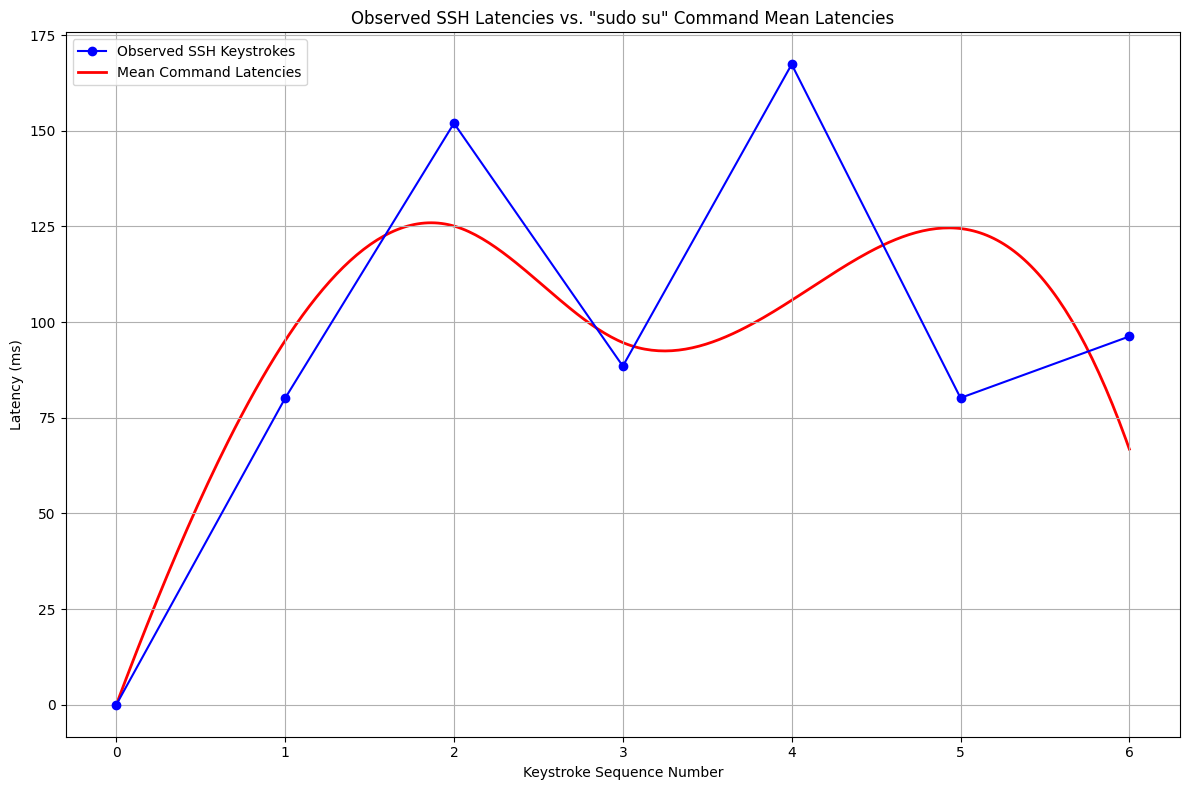

In [350]:
command = 'sudo su'
plot_ssh_vs_command(ssh[2], get_mean_latencies(command, cmds[command]), command)

In [351]:
# Remove RETURN from intercept- seems better for matching to commands
# Probably because of the "pause", double-checking a command before running it.
for sequence in ssh:
    sequence.pop()
try:
    ssh.remove([])
except:
    pass

In [352]:
find_best_match(ssh[2], cmds)

[('df -hT /', 0.3197322837909839),
 ('rm -rf /tmp/*', 0.3501134426762639),
 ('cat /etc/passwd', 0.3629469206798097),
 ('sudo apt upgrade ', 0.37089561196265636),
 ('curl http://', 0.385297385378211),
 ('tail /var/log/syslog', 0.4048344996875354),
 ('cat /etc/resolv.conf', 0.4090353071384626),
 ('sudo su', 0.41065041672931585),
 ('cat /etc/hosts', 0.43270735792408804),
 ('tar --help', 0.4574526487242299),
 ('vim ', 0.4645660140754227),
 ('sudo', 0.47353671899506333),
 ('touch ', 0.474961107701612),
 ('mv * ../', 0.49295249663564095),
 ('nano ', 0.5123122703193639),
 ('wget https://', 0.5386429341763814),
 ('uptime', 0.553214436057197),
 ('sudo apt update', 0.5558908818816386),
 ('netstat -tuln', 0.5572080838210159),
 ('ping -c 1 9.9.9.9', 0.604858494885093),
 ('exit', 0.6093942231912194),
 ('whoami', 0.6789907254238293),
 ('ss -tuln', 0.6899919744623172),
 ('cd', 0.913599615100943),
 ('id', 0.9547618475549923)]

In [353]:
[is_it_sudo(ssh[i], cmds) for i in range(len(ssh))] 

[False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [354]:
confidence = OrderedDict({
    0.2: 'Very confident',
    0.5: 'Confident',
    0.8: 'Somewhat confident',
    1: 'Not that confident',
    100: 'Fail',
})

In [355]:
[f"{match[0]} - {match[1]}: "+[confidence[x] for x in confidence.keys() if match[1] <= x][0] for match in [find_best_match(ssh[i], cmds)[0] for i in range(len(ssh))]]

['sudo apt upgrade  - 0.5394455643691872: Somewhat confident',
 'systemctl status  - 0.5927303838841784: Somewhat confident',
 'df -hT / - 0.3197322837909839: Confident',
 'cat /etc/hosts - 0.6240965905382237: Somewhat confident',
 'cat /etc/hosts - 0.5082970508023236: Somewhat confident',
 'mv * ../ - 0.6961136175223173: Somewhat confident',
 'tail /var/log/syslog - 0.14725638159499757: Very confident',
 'wget https:// - 0.16456092962926402: Very confident',
 'uptime - 0.2845382440682646: Confident',
 'cat /etc/hosts - 0.46613383232370575: Confident',
 'sudo apt upgrade  - 0.637899873242105: Somewhat confident',
 'mv * ../ - 1.027255880091211: Fail',
 'df -hT / - 0.4022434609040982: Confident',
 'touch  - 0.4542034657833189: Confident',
 'systemctl restart  - 0.445921006224446: Confident',
 'exit - 0.19418610318151172: Very confident']